# Scrapper (Webmining)

#### Importamos las librerias necesarias

In [ ]:
import pandas as pd
from bs4 import BeautifulSoup
from selenium import webdriver

#### Esta función utiliza Selenium para cargar una página web en un navegador, simula desplazarse hacia abajo y hacia arriba en la página para cargar completamente el contenido dinámico, y luego devuelve el código HTML completo de la página.

In [ ]:
def get_html(url):
    browser = webdriver.Firefox()
    browser.get(url)

    browser.implicitly_wait(10)

    scroll_amount = 2000
    current_height = browser.execute_script("return document.body.scrollHeight")

    max_counter = 0

    while True:
        browser.execute_script(f"window.scrollTo(0, {current_height});")
        browser.execute_script(f"window.scrollTo(0, {current_height - scroll_amount});")
        new_height = browser.execute_script("return document.body.scrollHeight")
        if new_height >= 20000:
            break
        current_height = new_height
        max_counter += 1
        if max_counter >= 5000:
            break
    html = browser.page_source
    browser.quit()
    return html

#### Esta función analiza el HTML de una página web para extraer los comentarios de los usuarios junto con sus calificaciones asociadas, y los devuelve como una lista de tuplas.

In [ ]:
def get_comments(html):
    soup = BeautifulSoup(html, "html.parser")
    articles = soup.find_all("article", class_="ui-review-capability-comments__comment")

    data = []

    for article in articles:
        rating_div = article.find(
            "div", class_="ui-review-capability-comments__comment__rating"
        )
        rating = rating_div.find("p", class_="andes-visually-hidden")
        rating_info = rating.text.strip()

        comment = article.find(
            "p", class_="ui-review-capability-comments__comment__content"
        ).text.strip()

        rating_info = rating_info.split(" ")[1]

        if int(rating_info) < 3:
            rating_info = 0
        else:
            rating_info = 1

        data.append((rating_info, comment))

    return data

#### Por útlimo, se utilizan las siguientes urls para obtener sus datos, una vez con esos datos completos se pasan a un archivo de excel usando pandas

In [ ]:
urls = [
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM19671372?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1385142136?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1453562130?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1310553268?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1529227728?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM2413812916?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1483602610?noIndex=true&access=view_all&modal=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM26374823?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1595869350?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1436939565?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1918786987?noIndex=true&access=view_all&modal=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM23718286?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM27953242?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1423798166?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1458795279?noIndex=true&access=view_all&modal=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM15567959?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM23537280?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM25929225?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://www.mercadolibre.com.mx/noindex/catalog/reviews/MLM27144027?noIndex=true&access=view_all&modal=true&controlled=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM1958181837?noIndex=true&access=view_all&modal=true",
        "https://articulo.mercadolibre.com.mx/noindex/catalog/reviews/MLM2041772158?noIndex=true&access=view_all&modal=true",
    ]

data_list = []

for url in urls:
    html = get_html(url)
    data = get_comments(html)
    data_list.extend(data)

print(data_list)
df = pd.DataFrame(data_list, columns=["rating", "comment"])
df.to_csv("comments.csv", index=False)

# MODELO BAYES

#### Importamos las librerias necesarias

In [76]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn import svm
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.neural_network import MLPClassifier
import seaborn as sns

#### Creamos nuestras variables globales

In [77]:
global PROHIBIDAS
PROHIBIDAS = [""]
global ARCHIVO
ARCHIVO = "comments.csv"
global DATASET
DATASET = pd.read_csv(ARCHIVO)


# Naive Bayes

#### El calculo de probabilidades iniciales para el modelo de Naive bayes, dividiendo la cantidad de Reviews negativas/positivas sobre la cantidad de reviews totales

In [78]:
def Probabilidades_Iniciales(dataset):
    Numero_Reviews_Positivas = 0
    Numero_Reviews_Negativas = 0
    for i in range(len(dataset)):
        if dataset["comment"].iloc[i] != "":
            if dataset["rating"].iloc[i] == 1:
                Numero_Reviews_Positivas += 1
            if dataset["rating"].iloc[i] == 0:
                Numero_Reviews_Negativas += 1
    Probabilaidad_Negativa = Numero_Reviews_Negativas/len(dataset)
    Probabilidad_Positiva = Numero_Reviews_Positivas/len(dataset)
    return Probabilaidad_Negativa, Probabilidad_Positiva


#### Separamos Las palabras de las reviews negativas y las palabras de las reviews positivas

In [79]:
def Vectores_Palabras(dataset):
    Palabras_Positivas = []
    Palabras_Negativas = []
    Largo = len(dataset)
    for i in range(Largo):
        if dataset["comment"].iloc[i] != "": 
            if dataset["rating"].iloc[i] == 1 : 
                Palabras_Positivas.append(dataset["comment"].iloc[i])
            if dataset["rating"].iloc[i] == 0: 
                Palabras_Negativas.append(dataset["comment"].iloc[i])
    return Palabras_Positivas, Palabras_Negativas

#### Filtramos las palabras quitando las 'stopwords', verificando que no esten prohibidas y quitando aquellas que no sean palabras

In [80]:
def Filtar_Palabras(Palabras):
    Palabras_Filtradas = []
    for review in Palabras:
        if isinstance(review, str):  # Check if the element is a string
            tokens = word_tokenize(review)
            stopwords_ingles = set(stopwords.words('spanish'))
            Palabras_Filtradas.extend([Palabra.lower() for Palabra in tokens
                                        if Palabra.isalpha() and Palabra.lower()
                                        not in stopwords_ingles and Palabra.lower() not in PROHIBIDAS])
    return Palabras_Filtradas


#### Calculamos las probabilidades de aparecer verificando las veces que esa palabra aparece sobre la cantidad de palabraas en el banco de palabras que se seleccione. A la probabilidad se le suma 1 ya que si es 0 afectaria los resultados

In [81]:
def Probabilidad_Palabra(Palabra, Review):
    Probabilidad_Palabra = (Review.count(Palabra)+1) / len(Review)
    return Probabilidad_Palabra

#### Calculamos las palabras mas frecuentemente utilizadas

In [82]:
#Funcion para obtener la frecuencia de las palabras en las reviews
def Frecuencia_Palabras(Palabras):
    Frecuencia = Counter(Palabras)
    print(Frecuencia.most_common(10))
    return Frecuencia


#### La idea básica detrás del algoritmo de Naive Bayes es calcular la probabilidad de que una instancia pertenezca a una clase particular basada en la evidencia proporcionada por sus características. En el caso de un clasificador de texto, las características son las palabras en el texto y las clases son las categorías a las que puede pertenecer el texto 

In [83]:
def Naive_Bayes(Review, Palabras):
    Probabilidad = 1
    if not isinstance(Review, str):
        Review = str(Review)
    Review_Token = word_tokenize(Review)
    for Palabra in Review_Token:
        if Palabra not in Palabras:
            Probabilidad = Probabilidad * 1.
        else:
            Probabilidad = Probabilidad + Probabilidad_Palabra(Palabra, Palabras)
    return Probabilidad

#### Empezamos a probar nuestro modelo, multiplicamos la probabilidad de aparecer dentro de cada categoria, y lo multiplicamos por su respectiva posibilidad de que una reviews sea positiva o negativa, regresamos el valor que sea mayor

In [84]:
def Pruebas(Palabras_Positivas, Palabras_Negativas,Review_Prueba,dataset):
    Probabilidad_Inicial_Negativa, Probabilidad_Inicial_Positiva = Probabilidades_Iniciales(dataset)
    Probabilidad_De_Ser_Positiva = Naive_Bayes(Review_Prueba, Palabras_Positivas)
    Probabilidad_De_Ser_Positiva *= Probabilidad_Inicial_Positiva
    Probabilidad_De_Ser_Negativa = Naive_Bayes(Review_Prueba, Palabras_Negativas)
    Probabilidad_De_Ser_Negativa *= Probabilidad_Inicial_Negativa
    Resultado = 0
    if Probabilidad_De_Ser_Positiva > Probabilidad_De_Ser_Negativa:
        Resultado = 1
    if Probabilidad_De_Ser_Positiva and Probabilidad_De_Ser_Negativa == 0:
        Resultado = -1
    if Resultado == 0:
        print(Probabilidad_De_Ser_Negativa, Probabilidad_De_Ser_Positiva)
    return Resultado

#### Creamos la matriz de confusion y su respectiva grafica, tomando los datos predecidos de nuestro dataset de testeo

In [85]:

def Matriz_Confusion(dataset, Palabras_Positivas, Palabras_Negativas):
    y_true = []
    y_pred = []
    for i in range(len(dataset)):
        if dataset["comment"].iloc[i] != "":
            if dataset["rating"].iloc[i] == 1:
                y_true.append(1)
            if dataset["rating"].iloc[i] == 0:
                y_true.append(0)
        if Pruebas(Palabras_Positivas, Palabras_Negativas, dataset["comment"].iloc[i], dataset) == 1:
            y_pred.append(1)
        if Pruebas(Palabras_Positivas, Palabras_Negativas, dataset["comment"].iloc[i], dataset) == 0:
            y_pred.append(0)
            print("Comentario")
            print(dataset["comment"].iloc[i] + "\n")

    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    precision = (tp + tn) / (tp + tn + fp + fn)
    false_positive_rate = fp / (tn + fp)
    false_negative_rate = fn / (fn + tp)
    error_rate = 1 - precision
    positive_predictive_value = tp / (fp + tp)
    negative_predictive_value = tn / (tn + fn) if tn + fn != 0 else 0

    tabla = pd.DataFrame(data=[[precision], [error_rate], [false_positive_rate], [false_negative_rate], 
                                [positive_predictive_value], [negative_predictive_value]],
                         index=["Presicion", "Error", "Falsos Positivos", "Falsos Negativos",
                                "Acertividad Positiva", "Acertividad Negativa"], columns=["Valor"])
    print(tabla)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", annot_kws={"size": 16})
    plt.xlabel("Etiquetas Predichas")
    plt.ylabel("Etiquetas Verdaderas")
    plt.title("Matriz de Confusión")
    plt.show()

    return precision, false_positive_rate, false_negative_rate, error_rate, positive_predictive_value, negative_predictive_value


#### Creamos nuestra funcion main para llamar cada una de nuestras otras funciones

In [86]:
def main():
    df_train, df_test = train_test_split(DATASET, test_size=0.2, random_state=0)

    Palabras_Positivas_train, Palabras_Negativas_train = Vectores_Palabras(df_train)

    Palabras_Positivas_train = Filtar_Palabras(Palabras_Positivas_train)
    Palabras_Negativas_train = Filtar_Palabras(Palabras_Negativas_train)
    print()
    print('Palabras mas frecuentes en reviews positivas')
    Frecuencia_Palabras(Palabras_Positivas_train)
    print('Palabras mas frecuentes en reviews negativas')
    Frecuencia_Palabras(Palabras_Negativas_train)
    print()
    PrecisionB, FPBayes, FNBayes, ErrorBayes, APBayes, ANBayes = Matriz_Confusion(df_test, Palabras_Positivas_train, Palabras_Negativas_train)
    return PrecisionB, FPBayes, FNBayes, ErrorBayes, APBayes, ANBayes   




In [87]:
DATASET.head()

,rating,comment
0,1,Lo compre hace una semana cuando estaba con 10...
1,1,Lo compré apenas el 23 mayo 23 me encantó el p...
2,1,El producto asta el momento me a funcionado bi...
3,1,Me pareció excelente calidad precio por ahora ...
4,1,"8gb de ram + 3gb virtuales, 256gb de almacenam..."



Palabras mas frecuentes en reviews positivas
[('excelente', 333), ('bien', 324), ('producto', 310), ('calidad', 272), ('buena', 247), ('precio', 234), ('buen', 220), ('si', 153), ('fácil', 144), ('recomiendo', 126)]
Palabras mas frecuentes en reviews negativas
[('calidad', 33), ('producto', 32), ('agua', 26), ('bien', 25), ('mala', 22), ('si', 22), ('solo', 21), ('malo', 18), ('plástico', 15), ('verdad', 13)]

                         Valor
Presicion             0.862745
Error                 0.137255
Falsos Positivos      1.000000
Falsos Negativos      0.000000
Acertividad Positiva  0.862745
Acertividad Negativa  0.000000


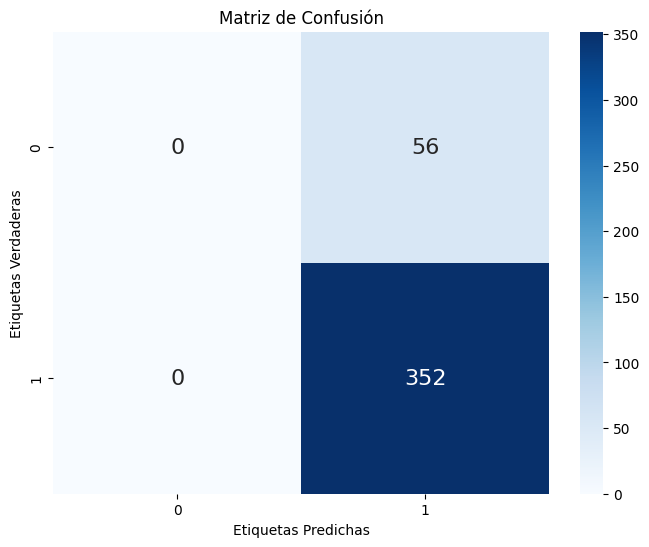

In [88]:
PrecisionB, FPBayes, FNBayes, ErrorBayes, APBayes, ANBayes = main()

# Modelo SVM

In [89]:
DATASET.head()

,rating,comment
0,1,Lo compre hace una semana cuando estaba con 10...
1,1,Lo compré apenas el 23 mayo 23 me encantó el p...
2,1,El producto asta el momento me a funcionado bi...
3,1,Me pareció excelente calidad precio por ahora ...
4,1,"8gb de ram + 3gb virtuales, 256gb de almacenam..."


#### Divimos el dataset en entrenamiento y prueba

In [90]:
#Obtenos y de la columna rating
y = DATASET['rating']
#Obtenemos X de la columna comment
X = DATASET

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

PalabrasP_train,PalabrasN_train = Vectores_Palabras(X_train)
PalabrasP_test,PalabrasN_test = Vectores_Palabras(X_test)

PalabrasP_train = Filtar_Palabras(PalabrasP_train)
PalabrasN_train = Filtar_Palabras(PalabrasN_train)

PalabrasP_test = Filtar_Palabras(PalabrasP_test)
PalabrasN_test = Filtar_Palabras(PalabrasN_test)

NumPalabrasP = Frecuencia_Palabras(PalabrasP_train)
#NumPalabrasN = Frecuencia_Palabras(PalabrasN_train)

# Por cada review obtenemos el numero de palabras y las dividimos entre de palabras positivas o negativas
X_trainNP = []
for i in range(len(X_train)):
    if X_train['rating'].iloc[i] == 1:
        X_trainNP.append(len(Filtar_Palabras([X_train['comment'].iloc[i]]))/len(PalabrasP_train))
    else:
        X_trainNP.append(len(Filtar_Palabras([X_train['comment'].iloc[i]]))/len(PalabrasN_train))

X_trainNP = pd.DataFrame(X_trainNP)
#X_trainNP

X_testNP = []
for i in range(len(X_test)):
    if X_test['rating'].iloc[i] == 1:
        X_testNP.append(len(Filtar_Palabras([X_test['comment'].iloc[i]]))/len(PalabrasP_test))
    else:
        X_testNP.append(len(Filtar_Palabras([X_test['comment'].iloc[i]]))/len(PalabrasN_test))

X_testNP = pd.DataFrame(X_testNP)
X_testNP

#Aplicamos el modelo de SVM
clf = svm.SVC(kernel = 'rbf')
clf.fit(X_trainNP, y_train)

[('excelente', 333), ('bien', 324), ('producto', 310), ('calidad', 272), ('buena', 247), ('precio', 234), ('buen', 220), ('si', 153), ('fácil', 144), ('recomiendo', 126)]


SVC()

In [91]:
y_pred = clf.predict(X_testNP)
y_pred [0:5]

array([1, 1, 1, 1, 0])

#### Matriz de Confusion

In [92]:
def plot_Confusion_Matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusion normalizada")
    else:
        print('Matriz de confusion sin normalizar')
    
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    

In [93]:
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.40      0.86      0.55        56
           1       0.97      0.80      0.88       352

    accuracy                           0.80       408
   macro avg       0.69      0.83      0.71       408
weighted avg       0.89      0.80      0.83       408



Matriz de confusion sin normalizar
[[ 48   8]
 [ 72 280]]


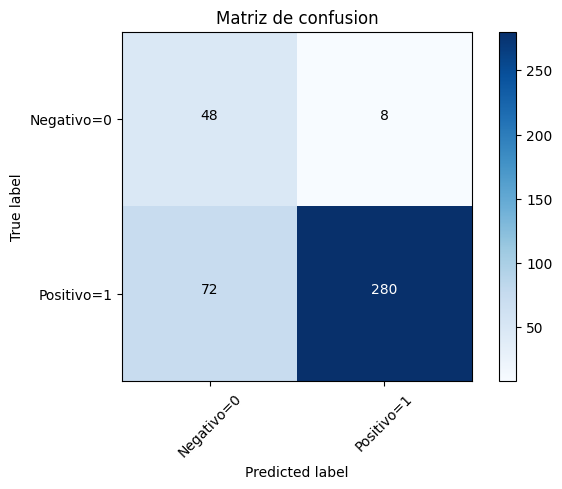

In [94]:
plt.figure()
plot_Confusion_Matrix(cnf_matrix, classes=['Negativo=0', 'Positivo=1'], normalize=False, title='Matriz de confusion')

##### Precision Global, Error Global, Falsos Positivo, Falsos Negativo, Acertividad Positiva y Negativa

In [95]:
# Calculamos la precision y error global
from sklearn.metrics import f1_score
PrecisionG = f1_score(y_test, y_pred, average='weighted')
print("Precisión Global: ", PrecisionG)
ErrorSVM = 1 - PrecisionG
print("Error Global: ", ErrorSVM)

# Calculamos los falsos positivos y falsos negativos
FP = cnf_matrix[0,1]/(cnf_matrix[0,1] + cnf_matrix[0,0])
FN = cnf_matrix[1,0]/(cnf_matrix[1,0] + cnf_matrix[1,1])
print("Falsos Positivos: ", FP)
print("Falsos Negativos: ", FN)

# Asertividad Positiva y Asertividad Negativa
AsertividadP = (cnf_matrix[0,0] + cnf_matrix[1,1])/(cnf_matrix[0,0] + cnf_matrix[1,1] + cnf_matrix[0,1] + cnf_matrix[1,0])
AsertividadN = cnf_matrix[1,1]/(cnf_matrix[1,1] + cnf_matrix[0,1])
print("Asertividad Positiva: ", AsertividadP)
print("Asertividad Negativa: ", AsertividadN)


Precisión Global:  0.8297682709447416
Error Global:  0.1702317290552584
Falsos Positivos:  0.14285714285714285
Falsos Negativos:  0.20454545454545456
Asertividad Positiva:  0.803921568627451
Asertividad Negativa:  0.9722222222222222


# MODELO NNBP

##### creamos una función que busca quitar los valores nulo, pueso que algunas review solo cuenta con el raiting mas no con comentario.

In [109]:
def Quitar_Valores_Nulos():
    for i in range(len(DATASET)):
        if DATASET.loc[i, "comment"] == "":
            if DATASET.loc[i, "rating"] == 1:
                DATASET.loc[i, "comment"] = "bueno"
            if DATASET.loc[i, "rating"] == 0:
                DATASET.loc[i, "comment"] = "malo"

##### NOTA IMPORTANTE: para poder usar el DATASET debemos limpiar por lo tanto aquí aplicamos algunas de las funciones antes implementadas como lo son: 
##### 1- def Filtrar_palabras()
##### 2- def Probabilidad_Palabra()


In [110]:
def Vectores_Palabras_nnbp(dataset):
    Palabras = []
    Largo = len(dataset)
    for i in range(Largo):
        Palabras.append(DATASET["comment"][i])
    return Palabras

##### Creamos una función cuyo objetivo es sacar la probabilidad de cada palabra, esto lo necesitamos por que una vez tengamos la probabilidad de cada palabra, procederemos a cambiar los textos de los comment a su equivalente en probailidad

In [111]:
def Probabilidad_Review(Review, Palabras):
    Probabilidades = []
    Review = Filtar_Palabras([Review])
    for Palabra in Review:
        Probabilidades.append(Probabilidad_Palabra(Palabra, Palabras))
    return np.array(Probabilidades)

##### en la siguiente funcion vamos a buscar el comentario más largo y vamos a rellenar con 0 los demas comentarios. esto con el objetivo que toda la matriz este del mismo nivel

In [112]:
def rellenar(X,Y,df_Test,Res_Test, Palabras_Entrenamiento, Palabras_EnFiltradas, Res_Train):
    Matriz_Entrenamiento = []
    max_length = 0
    for review in Palabras_Entrenamiento:
        prob_review = Probabilidad_Review(review, Palabras_EnFiltradas)
        Matriz_Entrenamiento.append(prob_review)
        max_length = max(max_length, len(prob_review))

    for i in range(len(Matriz_Entrenamiento)):
        if len(Matriz_Entrenamiento[i]) < max_length:
            Matriz_Entrenamiento[i] = np.pad(Matriz_Entrenamiento[i], (0, max_length - len(Matriz_Entrenamiento[i])), 'constant', constant_values=0)
    Matriz_Entrenamiento = np.array(Matriz_Entrenamiento, dtype=float)
    Res_Train = np.array(Res_Train)
    instancia_red = red_neuronal(Matriz_Entrenamiento, Res_Train)
    # Llama a prueba_red_neuronal con la instancia de la red y los datos de prueba
    matriz_confusion, precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP = prueba_red_neuronal(df_Test, Res_Test, instancia_red)
    return precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP 


##### vamos a generar la red neuronal 

In [113]:
def red_neuronal(matriz_entrenamiento, res_train):
    instancia_red = MLPClassifier()
    #print(instancia_red)
    instancia_red.fit(matriz_entrenamiento, res_train)
    #print("Las predicciones del testing son: {}".format(instancia_red.predict(matriz_entrenamiento)))
    return instancia_red

##### esta función realiza la preparación de los datos de prueba, hace predicciones utilizando la instancia de la red neuronal y retorna la matriz de confusión resultante.

In [114]:
def prueba_red_neuronal(df_Test, Res_Test, instancia_red):
    Palabras_Test = Vectores_Palabras_nnbp(df_Test)
    Palabras_Test_Filtradas = Filtar_Palabras(Palabras_Test)
    Matriz_Test = []
    max_length = 0
    for review in Palabras_Test:
        prob_review = Probabilidad_Review(review, Palabras_Test_Filtradas)
        Matriz_Test.append(prob_review)
        max_length = max(max_length, len(prob_review))

    for i in range(len(Matriz_Test)):
        if len(Matriz_Test[i]) < max_length:
            Matriz_Test[i] = np.pad(Matriz_Test[i], (0, max_length - len(Matriz_Test[i])), 'constant', constant_values=0)
    # Llama a la función predicciones con la instancia de la red, los datos de prueba y las etiquetas de prueba
    matriz_confusion, precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP = predicciones(instancia_red, Matriz_Test, Res_Test)
    return matriz_confusion, precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP 

##### generamos una función que imprimira las predicciones de la red

In [115]:
def predicciones(instancia_red, matriz_test, Res_Test):
    # Utiliza los datos de prueba y la instancia de la red para hacer predicciones
    Predicciones = instancia_red.predict(matriz_test)
    # Calcula la matriz de confusión utilizando las predicciones y las etiquetas verdaderas (Res_Test)
    Matriz_Confusion = confusion_matrix(Res_Test, Predicciones)
    # Devuelve la matriz de confusión
    precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP = confusion(Matriz_Confusion, Res_Test, Predicciones)
    return Matriz_Confusion, precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP 

##### Creamos una función para imprimir las variables

In [116]:
def plot_Confusion_Matrix(cm, classes, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matriz de confusión normalizada")
    else:
        print('Matriz de confusión sin normalizar')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


##### hacemos la matriz de confusion para ver el rendimiento del modelo 

In [117]:
def confusion(Matriz_Confusion, Res_Test, Predicciones):
    tn, fp, fn, tp = confusion_matrix(Res_Test, Predicciones).ravel()
    precision = (tn + tp) / (tn + fp + fn + tp)
    FalsosPositivos = fp / (tn + fp)
    FalsosNegativos = fn / (fn + tp)
    Error = 1 - precision
    AcertividadPositiva = tp / (fp + tp)
    if tn + fn == 0:
        AcertividadNegativa = 0  # or 1, depending on your preference
    else:
        AcertividadNegativa = tn / (tn + fn)
    
    # Crear el DataFrame con la matriz de confusión
    df_confusion = pd.DataFrame(Matriz_Confusion, columns=['Predicción Negativa', 'Predicción Positiva'], index=['Real Negativa', 'Real Positiva'])
    # Imprimir la tabla de la matriz de confusión
    #print(df_confusion)
     # Llamar a la función plot_Confusion_Matrix
    plot_Confusion_Matrix(Matriz_Confusion, classes=['Negativo=0', 'Positivo=1'], normalize=False, title='Matriz de confusión')

    
    # Imprimir otros datos en el formato deseado
    print("\nPrecision Global, Falsos Positivos, Falsos Negativos, Error Global, Acertividad Positiva, Acertividad Negativa")
    print((precision, FalsosPositivos, FalsosNegativos, Error, AcertividadPositiva, AcertividadNegativa))

    return precision, FalsosPositivos, FalsosNegativos, Error, AcertividadPositiva, AcertividadNegativa




##### generamos el main del código de redes

Matriz de confusión sin normalizar
[[  0 104]
 [  0 915]]


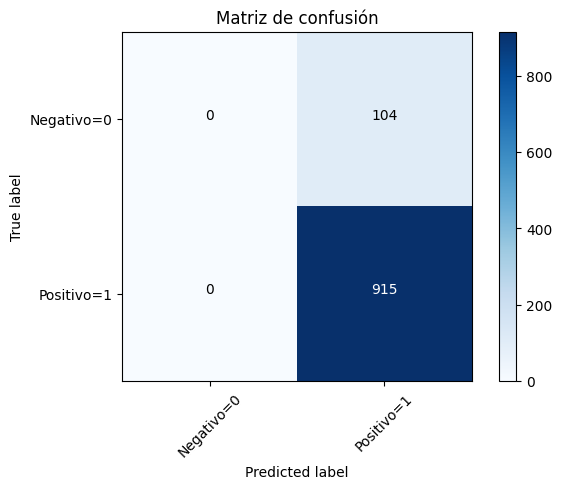


Precision Global, Falsos Positivos, Falsos Negativos, Error Global, Acertividad Positiva, Acertividad Negativa
(0.8979391560353287, 1.0, 0.0, 0.1020608439646713, 0.8979391560353287, 0)


In [118]:
def main_Redes():
    Quitar_Valores_Nulos()
    X = DATASET["comment"]
    Y = DATASET["rating"]
    df_Test, df_Train, Res_Test, Res_Train = train_test_split(X, Y, test_size=0.5, random_state=42)
    Palabras_Entrenamiento = Vectores_Palabras_nnbp(df_Train)
    Palabras_EnFiltradas = Filtar_Palabras(Palabras_Entrenamiento)
    precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP = rellenar(X,Y,df_Test,Res_Test, Palabras_Entrenamiento, Palabras_EnFiltradas, Res_Train)
    return precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP 


precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP = main_Redes()

# Tabla comparativa

In [119]:
# PrecisionB, FPBayes, FNBayes, ErrorBayes, APBayes, ANBayes
dataBayes = {'Precisión Global': [PrecisionB],'Error Global' : [ErrorBayes],'Asertividad Positiva': [APBayes], 'Asertividad Negativa': [ANBayes], 'Falso Positivo': [FPBayes], 'Falso Negativo': [FNBayes]}
df = pd.DataFrame(dataBayes)
df
# Cambiar el nombre de las filas
df = df.rename(index={0: 'Bayes'})
df

,Precisión Global,Error Global,Asertividad Positiva,Asertividad Negativa,Falso Positivo,Falso Negativo
Bayes,0.862745,0.137255,0.862745,0,1.0,0.0


In [120]:
# SVM
dataSVM = {'Precisión Global': [PrecisionG],'Error Global' : [ErrorSVM],'Asertividad Positiva': [AsertividadP], 'Asertividad Negativa': [AsertividadN], 'Falso Positivo': [FP], 'Falso Negativo': [FN]}
df = pd.DataFrame(dataSVM)
df
# Cambiar el nombre de las filas
df = df.rename(index={0: 'SVM'})
df

,Precisión Global,Error Global,Asertividad Positiva,Asertividad Negativa,Falso Positivo,Falso Negativo
SVM,0.829768,0.170232,0.803922,0.972222,0.142857,0.204545


In [122]:
# NNBP
#precisionNNBP, FPNNBP, FNNNBP, ErrorNNBP, APNNBP, ANNNBP 
dataNNBP = {'Precisión Global': [precisionNNBP], 'Error Global' : [ErrorNNBP],'Asertividad Positiva': [APNNBP], 'Asertividad Negativa': [ANNNBP], 'Falso Positivo': [FPNNBP], 'Falso Negativo': [FNNNBP]}
df = pd.DataFrame(dataNNBP)
df
# Cambiar el nombre de las filas
df = df.rename(index={0: 'NNBP'})
df

,Precisión Global,Error Global,Asertividad Positiva,Asertividad Negativa,Falso Positivo,Falso Negativo
NNBP,0.897939,0.102061,0.897939,0,1.0,0.0


In [129]:
df = pd.DataFrame()

df['Precisión Global'] = None
df['Error Global'] = None
df['Asertividad Positiva'] = None
df['Asertividad Negativa'] = None
df['Falso Positivo'] = None
df['Falso Negativo'] = None

df.loc["Bayes"] = [PrecisionB, ErrorBayes, APBayes, ANBayes, FPBayes, FNBayes]
df.loc["SVM"] = [PrecisionG, ErrorSVM, AsertividadP, AsertividadN, FP, FN]
df.loc["NNBP"] = [precisionNNBP, ErrorNNBP, APNNBP, ANNNBP, FPNNBP, FNNNBP]

df

,Precisión Global,Error Global,Asertividad Positiva,Asertividad Negativa,Falso Positivo,Falso Negativo
Bayes,0.862745,0.137255,0.862745,0.000000,1.000000,0.000000
SVM,0.829768,0.170232,0.803922,0.972222,0.142857,0.204545
NNBP,0.897939,0.102061,0.897939,0.000000,1.000000,0.000000
